# Import Libraries and Load Dataset

In [1]:
%%capture
#!git clone https://github.com/huggingface/transformers.git
!pip install datasets evaluate transformers[sentencepiece]
!pip install rouge_score
!pip install underthesea
!pip install pyvi
!pip install gdown

In [2]:
#%%capture

import gdown

!gdown 1jWDnP1xF01_pmeJYsRHxSVBkLZ0I9LAt #utils T5 for VQA

Downloading...
From (original): https://drive.google.com/uc?id=1jWDnP1xF01_pmeJYsRHxSVBkLZ0I9LAt
From (redirected): https://drive.google.com/uc?id=1jWDnP1xF01_pmeJYsRHxSVBkLZ0I9LAt&confirm=t&uuid=fb9aa419-8a17-427f-8cd9-5653be6e837f
To: /kaggle/working/utils.py
100%|████████████████████████████████████████| 109k/109k [00:00<00:00, 61.6MB/s]


In [3]:
from PIL import Image

import requests

import os
import shutil
import torch

from urllib.request import urlopen
from PIL import Image
import timm
import tqdm
import torch
from IPython.display import FileLink

In [4]:
!gdown 1q7_-PEQQ6IR3Ortz45vEiSiOnweRJ40H # cap train
!gdown 1wldmw8IJgX-nK2_yfo8fLx55KfWGIZhp # cap dev 

Downloading...
From: https://drive.google.com/uc?id=1q7_-PEQQ6IR3Ortz45vEiSiOnweRJ40H
To: /kaggle/working/vi_train_captions.json
100%|███████████████████████████████████████| 11.3M/11.3M [00:00<00:00, 228MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wldmw8IJgX-nK2_yfo8fLx55KfWGIZhp
To: /kaggle/working/vi_dev_captions.json
100%|███████████████████████████████████████| 1.14M/1.14M [00:00<00:00, 125MB/s]


In [5]:
import json

with open('/kaggle/working/vi_train_captions.json', encoding='utf-8') as f:
    cap_train = json.load(f)

with open('/kaggle/working/vi_dev_captions.json', encoding='utf-8') as f:
    cap_test = json.load(f)

train_json = json.load(open('/kaggle/input/dsc24-vimmsd/vimmsd-train.json'))
dev_json = json.load(open('/kaggle/input/dsc24-vimmsd/vimmsd-public-test.json'))

train_OCR_json = json.load(open('/kaggle/input/lovecat-ocr-dataset/OCP-easyOCR/ocr-results-train.json'))
dev_OCR_json = json.load(open('/kaggle/input/lovecat-ocr-dataset/OCP-easyOCR/ocr-results-dev.json'))
for item in train_OCR_json:
    item["OCR"] = ", ".join(item["OCR"])
for item in dev_OCR_json:
    item["OCR"] = ", ".join(item["OCR"])

train_objectRecognition_json = json.load(open('/kaggle/input/lovecat-objectrecognition-dataset/recognizeAnything-objectsRecognition/objects-recognition-train.json'))
dev_objectRecognition_json = json.load(open('/kaggle/input/lovecat-objectrecognition-dataset/recognizeAnything-objectsRecognition/objects-recognition-dev.json'))

# Image feature extraction

In [6]:
# images = []

# for key, item in train_json.items():
#     images.append(item['image'])

# for key, item in dev_json.items():
#     images.append(item['image'])

In [7]:
# source_all = ['/kaggle/input/dsc24-vimmsd/dev-images/dev-images',
#               '/kaggle/input/dsc24-vimmsd/train-images/train-images']

# destination = './images'
# #os.mkdir(destination)

# for source in source_all:
#     allfiles = os.listdir(source)
#     for f in allfiles:
#         src_path = os.path.join(source, f)
#         dst_path = os.path.join(destination, f)
#         shutil.copy(src_path, dst_path)

## BEiT

In [8]:
# model = timm.create_model(
#     'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
#     pretrained=True,
#     num_classes=0,  # remove classifier nn.Linear
# ).to('cuda')

# model = model.eval()
# data_config = timm.data.resolve_model_data_config(model)
# transforms = timm.data.create_transform(**data_config, is_training=False)

# img_w = {}

# def batch(iterable, n=1):
#     l = len(iterable)
#     for ndx in range(0, l, n):
#         yield iterable[ndx:min(ndx + n, l)]

In [9]:
# p = '/kaggle/working/images/'

# img_w = {}

# # get features for images, we will do this 3 images at a time to reduce time

# for x in tqdm.notebook.tqdm(batch(images, 3),total=int(len(images)/3)):
#     img = [Image.open(p + v).convert('RGB') for v in x]
#     print(x)

#     with torch.no_grad():
#         img  = torch.stack([transforms(i) for i in img]).to('cuda')
#         output = model.forward_features(img)[:,1:,:]

#     tmp_img_w = {k:v for k,v in zip(x,output)}

#     img_w.update(tmp_img_w)

#     del output
#     del tmp_img_w
#     del img
#     torch.cuda.empty_cache()

# torch.save(img_w, '/kaggle/working/beitv2-b-p.pt') # export for later used
# FileLink('/kaggle/working/beitv2-b-p.pt')

## Load extracted image features

In [10]:
import torch
from torch.nn.functional import normalize

img_w = torch.load('/kaggle/input/lovecat-beitv2-b-p/beitv2-b-p.pt') # already-saved features
len(img_w)

12218

In [11]:
img_w['ac7931bb887ad853b41675f07595bf04469970d1b099ffc8806a4ceaac7d7940.jpg'].shape

torch.Size([196, 768])

# Model

In [12]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

from utils import T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("VietAI/vit5-base")

model = T5ForConditionalGeneration.from_pretrained("VietAI/vit5-base").to('cuda')

model.add_imgw(img_w)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at VietAI/vit5-base and are newly initialized: ['resize_img_dim.weight', 'resize_img_dim.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Prepare datasets

In [13]:
def json_to_df(json):
    df = pd.DataFrame(json)
    df['add_caption'] = df['caption'].astype(str)
    df.drop(columns=['caption'], inplace=True)

    return df

In [14]:
import json
import re

stopword_path = '/kaggle/input/datasets-preprocesing/vietnamese-stopwords.txt'
emoji_file_path = '/kaggle/input/datasets-preprocesing/emoji_to_vietnamese.json'

def load_resources(stopword_path, emoji_file_path):
    # Đọc stopword từ file txt
    with open(stopword_path, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())

    # Đọc emoji từ file JSON
    with open(emoji_file_path, 'r', encoding='utf-8') as emoji_file:
        emoji_dict = json.load(emoji_file)

    return stopwords, emoji_dict

stopwords, emoji_dict = load_resources(stopword_path, emoji_file_path)
emoticon_dict = emoji_dict.get('biểu tượng cảm xúc', {})

# stopwords = sorted(stopwords, key=lambda x: (-len(x.split()), x))
# print('stopWords: ', stopwords)

def preprocess_text(text):
    def remove_stopwords(text):
        words = text.split()  # Split the text into individual words
        n = len(words)
        filtered_words = []
        i = 0
        
        while i < n:
          # Check phrases of lengths 4 to 2
          matched = False
          for length in range(4, 0, -1):
            if i + length <= n:
              phrase = ' '.join(words[i:i+length])
              if phrase in stopwords:
                matched = True
                i += length  # Skip over the matched phrase
                break
          if not matched:
            filtered_words.append(words[i])
            i += 1
        
        return ' '.join(filtered_words)
        
    def replace_emojis(text):
        for emoji, description in emoji_dict.get('emoji', {}).items():
            text = text.replace(emoji, description)  # Thay thế emoji bằng mô tả
        return text

    def replace_emoticons(text):
        for emoticon, meaning in emoticon_dict.items():
            # Nếu biểu cảm có ký tự cuối cùng là dấu ngoặc, cho phép lặp lại nhiều dấu
            if emoticon[-1] in {')', '}', ']', ':'}:
                emoticon_pattern = re.escape(emoticon[:-1]) + re.escape(emoticon[-1]) + r"+"
            else:
                emoticon_pattern = re.escape(emoticon)
            text = re.sub(emoticon_pattern, meaning, text)
        return text

    def normalize_text(text):
        text = text.lower()  # Chuyển thành chữ thường
        text = re.sub(r'(?<=\w)[\/\.\-\_,\\](?=\w)', '', text)  # Loại bỏ dấu chấm hoặc gạch nối trong từ
        return text

    text = replace_emojis(text)       # Thay thế emoji
    text = replace_emoticons(text)    # Thay thế biểu cảm
    text = normalize_text(text)       # Chuẩn hóa văn bản
    text = remove_stopwords(text)
    return text


In [15]:
import pandas as pd

cap_test_df = json_to_df(cap_test)
cap_train_df = json_to_df(cap_train)
cap_test_df['add_caption'] = cap_test_df['add_caption'].replace('- Tôi không biết.', '')
cap_train_df['add_caption'] = cap_train_df['add_caption'].replace('- Tôi không biết.', '')
# cap_train_df['add_caption'] = cap_train_df['add_caption'].astype(str).str.slice(0, 150)
# cap_test_df['add_caption'] = cap_test_df['add_caption'].astype(str).str.slice(0, 150)

train_df = pd.DataFrame(train_json).T
test_df = pd.DataFrame(dev_json).T # public test
train_df['caption'] = train_df['caption'].astype(str).str.slice(0, 100)
test_df['caption'] = test_df['caption'].astype(str).str.slice(0, 100)


train_OCR_df = pd.DataFrame(train_OCR_json)
test_OCR_df = pd.DataFrame(dev_OCR_json)
train_OCR_df['OCR'] = train_OCR_df['OCR'].astype(str).str.slice(0, 150)
test_OCR_df['OCR'] = test_OCR_df['OCR'].astype(str).str.slice(0, 150)

train_objectRecognition_df = pd.DataFrame(train_objectRecognition_json)
test_objectRecognition_df = pd.DataFrame(dev_objectRecognition_json)
train_objectRecognition_df['object_recognition'] = train_objectRecognition_df['object_recognition'].astype(str).str.slice(0, 100)
test_objectRecognition_df['object_recognition'] = test_objectRecognition_df['object_recognition'].astype(str).str.slice(0, 100)

cap_test_df.head()

,image,add_caption
0,2d06d8c77c741d001916199346cc112847e6bcf61b3dce...,Hình ảnh mô tả một truyện tranh có nội dung ch...
1,c981f23fc77cebd06ea872ea2c0ff6ec43a9d2517366ed...,Hình ảnh mô tả một đoạn truyện tranh có một nh...
2,342c9a8f91adeacde0f2c26dee3e6b86861b43e948d10b...,
3,2aa95c65c0a6444caff0657ed21e27fbc403af1727749a...,Bức ảnh mô tả một nhóm người trượt ván tuyết t...
4,9d6ebb26087b8d6051f77ef7cbf3e9a0d750baa41b45d7...,Hình ảnh mô tả một chiếc xe đang chạy trên đườ...


### Insert object recognition + OCR

In [16]:
# Merge `train_df` and `train_objectRecognition_df` on `image_id` in `train_df` and `image` in `json_df`
# print(train_objectRecognition_df.head)
# print(train_df.head)
train_df = pd.merge(train_df, train_objectRecognition_df, how='left', left_on='image', right_on='image')
test_df = pd.merge(test_df, test_objectRecognition_df, how='left', left_on='image', right_on='image')

train_df = pd.merge(train_df, train_OCR_df, how='left', left_on='image', right_on='image')
test_df = pd.merge(test_df, test_OCR_df, how='left', left_on='image', right_on='image')

train_df = pd.merge(train_df, cap_train_df, how='left', left_on='image', right_on='image')
test_df = pd.merge(test_df, cap_test_df, how='left', left_on='image', right_on='image')

# Concatenate `object_recognition` with `caption`
train_df['caption'] = train_df.apply(
    lambda row: row['OCR'] + '. ' + row['caption'] + '. ' + row['add_caption'],
    axis=1
)

test_df['caption'] = train_df.apply(
    lambda row: row['OCR'] + '. ' + row['caption'] + '. ' + row['add_caption'],
    axis=1
)


train_df.drop(columns=['object_recognition', 'OCR', 'add_caption'], inplace=True)
test_df.drop(columns=['object_recognition', 'OCR', 'add_caption'], inplace=True)
train_df.head()
train_df['caption'].iloc[0]

'. Cô ấy trên mạng vs cô ấy ngoài đời =))). Bức ảnh này được chụp từ một nền tảng truyền thông xã hội và cho thấy một người phụ nữ mặc một chiếc váy hở vai màu hồng và đứng cạnh một cái cây. Người phụ nữ đang mỉm cười và cười, cho thấy rằng cô ấy đang có một khoảng thời gian vui vẻ với bạn bè hoặc gia đình. Hình ảnh có thể là châm biếm hoặc hài hước, tùy thuộc vào quan điểm của người đó. Tuy nhiên, nội dung của bức ảnh mang tính giải trí và tích cực, cho thấy rằng người phụ nữ đang có một khoảng thời gian vui vẻ với bạn bè hoặc gia đình của mình.'

In [17]:
print('length cap before preprocessing: ', len(train_df['caption'].iloc[0]))

train_df['image_id'] = train_df['image'].astype(str)
test_df['image_id'] = test_df['image'].astype(str)

train_df['caption'] = train_df['caption'].apply(preprocess_text)
test_df['caption'] = test_df['caption'].apply(preprocess_text)

print('length cap after preprocessing: ', len(train_df['caption'].iloc[0]))

train_df['caption'] = train_df['caption'].astype(str).str.slice(0, 400)
test_df['caption'] = test_df['caption'].astype(str).str.slice(0, 400)

train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

train_df.drop(columns=['image'], inplace=True)
test_df.drop(columns=['image'], inplace=True)


train_df.head()
train_df['caption'].iloc[0]

length cap before preprocessing:  551
length cap after preprocessing:  266


'. mạng vs đời thái độ mỉa mai . ảnh chụp tảng truyền thông xã hội phụ nữ mặc váy hở vai màu hồng đứng cạnh cây. phụ nữ mỉm cười cười, vui vẻ bè gia đình. hình ảnh châm biếm hài hước, tùy quan đó. nhiên, nội dung ảnh giải trí tích cực, phụ nữ vui vẻ bè gia đình mình.'

In [18]:
import pandas as pd

from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['label'])  # Features
y = train_df['label']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_test, y_test], axis=1)

In [19]:
print(train_df.shape, val_df.shape, test_df.shape)

(11137, 3) (1238, 3) (1413, 3)


In [20]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, TrainingArguments, Seq2SeqTrainingArguments
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["inputs"], max_length=400, truncation=True, padding=True
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["labels"], max_length=32, truncation=True, padding=True
        )
    model_inputs['labels'] = labels['input_ids']
    model_inputs['input_ids'] = model_inputs['input_ids']
    model_inputs["image_id"] = examples["image_id"]
    
    return model_inputs

In [21]:
dict_obj = {}

dict_obj['inputs'] = train_df['caption']
dict_obj['labels'] =  train_df['label']
dict_obj['image_id'] = train_df['image_id']
train_dataset = Dataset.from_dict(dict_obj)
tokenized_train_datasets = train_dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=8)

dict_obj = {}
dict_obj['inputs'] = val_df['caption']
dict_obj['labels'] =  val_df['label']
dict_obj['image_id'] = val_df['image_id']
val_dataset = Dataset.from_dict(dict_obj)
tokenized_val_datasets = val_dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=8)


#0:   0%|          | 0/2 [00:00<?, ?ba/s]

#1:   0%|          | 0/2 [00:00<?, ?ba/s]

#2:   0%|          | 0/2 [00:00<?, ?ba/s]

#3:   0%|          | 0/2 [00:00<?, ?ba/s]

#4:   0%|          | 0/2 [00:00<?, ?ba/s]

#5:   0%|          | 0/2 [00:00<?, ?ba/s]

#6:   0%|          | 0/2 [00:00<?, ?ba/s]

#7:   0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#4:   0%|          | 0/1 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


#5:   0%|          | 0/1 [00:00<?, ?ba/s]

#6:   0%|          | 0/1 [00:00<?, ?ba/s]

#7:   0%|          | 0/1 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

In [22]:
import random

import numpy as np

import torch

def set_SEED():
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [23]:
import os
from transformers.optimization import Adafactor, AdafactorSchedule
from transformers import DataCollatorForSeq2Seq
from utils import DataCollatorForSeq2Seq

os.environ["WANDB_DISABLED"] = "True"
set_SEED()

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

#Adam
training_args = Seq2SeqTrainingArguments(output_dir="./checkpoint",
                                      do_train=True,
                                      do_eval=True,
                                      num_train_epochs=2,
                                      learning_rate=1e-4,
                                      warmup_ratio=0.05,
                                      weight_decay=0.01,
                                      per_device_train_batch_size=8,
                                      per_device_eval_batch_size=8,
                                      logging_dir='./log',
                                      group_by_length=True,
                                      save_strategy="steps",
                                      evaluation_strategy="steps",
                                      save_total_limit=5,
                                      eval_steps=100,
                                      logging_steps = 100,
                                      save_steps=100,
                                      load_best_model_at_end= True,
                                      fp16=True,
                                      seed=42,
                                      )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [24]:
tokenized_train_datasets

Dataset({
    features: ['labels', 'image_id', 'input_ids', 'attention_mask'],
    num_rows: 11137
})

In [25]:
tokenized_val_datasets

Dataset({
    features: ['labels', 'image_id', 'input_ids', 'attention_mask'],
    num_rows: 1238
})

In [26]:
trainer = Seq2SeqTrainer(
    model = model,
    args = training_args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_val_datasets,
    data_collator=data_collator,
)

trainer.train()

Step,Training Loss,Validation Loss
100,3.991700,0.196588
200,0.169100,0.123758
300,0.132300,0.164467
400,0.140100,0.117793
500,0.111700,0.117610
600,0.122000,0.132503
700,0.116800,0.109171
800,0.111800,0.108310
900,0.117600,0.106552
1000,0.111000,0.102078


TrainOutput(global_step=2786, training_loss=0.24067168020123814, metrics={'train_runtime': 1323.8952, 'train_samples_per_second': 16.825, 'train_steps_per_second': 2.104, 'total_flos': 5659155744215040.0, 'train_loss': 0.24067168020123814, 'epoch': 2.0})

In [27]:
import matplotlib.pyplot as plt
import json

# save loss
log_history = {'log_history':trainer.state.log_history}

with open('logs.json', 'w', encoding='utf-8') as f:
    json.dump(log_history, f, ensure_ascii=False, indent=4)

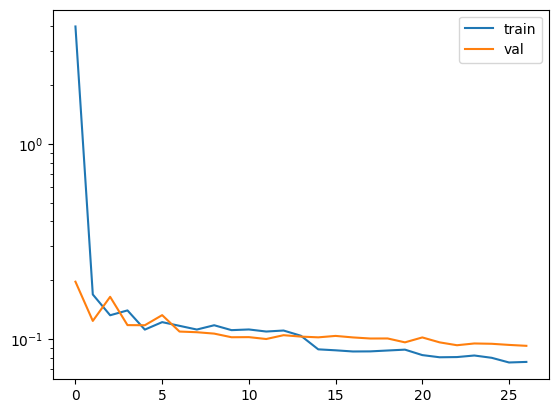

In [28]:
from matplotlib import pyplot

train_loss = {i['step']:i['loss'] for i in log_history['log_history'] if 'loss' in i.keys()}
eval_loss = {i['step']:i['eval_loss'] for i in log_history['log_history'] if 'eval_loss' in i.keys()}
plt.plot(list(train_loss.values()))
plt.plot(list(eval_loss.values()))

plt.yscale('log')
plt.legend(['train','val'])

# Load checkpoints and predict

In [29]:
torch.cuda.empty_cache()
# model = T5ForConditionalGeneration.from_pretrained("/kaggle/working/checkpoint/checkpoint-2700")
# model.to('cuda')
# model.add_imgw(img_w)

In [30]:

dict_obj = {}
dict_obj['inputs'] = test_df['caption']
dict_obj['labels'] =  test_df['label']
dict_obj['image_id'] = test_df['image_id']
test_dataset = Dataset.from_dict(dict_obj)
tokenized_test_datasets = test_dataset.map(preprocess_function, batched=True, remove_columns=['inputs'], num_proc=8)

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#4:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#5:   0%|          | 0/1 [00:00<?, ?ba/s]

#7:   0%|          | 0/1 [00:00<?, ?ba/s]

#6:   0%|          | 0/1 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your 

In [31]:
import gc
torch.cuda.empty_cache()
gc.collect()

2275

In [32]:
tokenized_test_datasets

Dataset({
    features: ['labels', 'image_id', 'input_ids', 'attention_mask'],
    num_rows: 1413
})

In [33]:
#test executing time: 2888s ~ 48m
import torch 
import numpy as np
from datasets import load_metric
metrics = load_metric('accuracy')

torch.cuda.empty_cache()
max_target_length = 10
dataloader = torch.utils.data.DataLoader(tokenized_test_datasets, collate_fn=data_collator, batch_size=4) #replace tokenized_dev_datasets with tokenized_test_datasets

predictions = []
references = []

for i, batch in enumerate(tqdm(dataloader)):
    # greedy search
    outputs = model.generate(image_id = batch['image_id'],
        input_ids=batch['input_ids'].to('cuda'),
        max_length=max_target_length,
        attention_mask=batch['attention_mask'].to('cuda'),
        return_dict_in_generate=True, output_attentions=True,)

    #beam search for now   
    # outputs = model.generate(
    #     image_id = np.repeat(batch['image_id'], 7),
    #     input_ids=batch['input_ids'].to('cuda'),
    #     max_length=max_target_length,
    #     attention_mask=batch['attention_mask'].to('cuda'),
    #     return_dict_in_generate=True, output_attentions=True,
    #     num_beams=7,
    #     no_repeat_ngram_size=2)
    
    with tokenizer.as_target_tokenizer():
        outputs = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in outputs.sequences]
        labels = np.where(batch['labels'] != -100,  batch['labels'], tokenizer.pad_token_id)
        # actuals = [tokenizer.decode(out, clean_up_tokenization_spaces=False, skip_special_tokens=True) for out in labels]

    predictions.extend(outputs)


  0%|          | 0/354 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [34]:
len(predictions)

1413

In [35]:
def postprocessing(t):
    t = t.lower()
    t = t.replace('\\','')
    return t

test_predicted = {k:postprocessing(i) for k,i in zip(dev_json.keys(),predictions)}

In [36]:
test_predicted

{'0': 'multi-sarcasm',
 '1': 'multi-sarcasm',
 '2': 'multi-sarcasm',
 '3': 'not-sarcasm',
 '4': 'not-sarcasm',
 '5': 'not-sarcasm',
 '6': 'not-sarcasm',
 '7': 'not-sarcasm',
 '8': 'not-sarcasm',
 '9': 'not-sarcasm',
 '10': 'multi-sarcasm',
 '11': 'multi-sarcasm',
 '12': 'not-sarcasm',
 '13': 'not-sarcasm',
 '14': 'not-sarcasm',
 '15': 'not-sarcasm',
 '16': 'not-sarcasm',
 '17': 'not-sarcasm',
 '18': 'not-sarcasm',
 '19': 'not-sarcasm',
 '20': 'multi-sarcasm',
 '21': 'multi-sarcasm',
 '22': 'not-sarcasm',
 '23': 'multi-sarcasm',
 '24': 'not-sarcasm',
 '25': 'not-sarcasm',
 '26': 'not-sarcasm',
 '27': 'not-sarcasm',
 '28': 'not-sarcasm',
 '29': 'not-sarcasm',
 '30': 'multi-sarcasm',
 '31': 'not-sarcasm',
 '32': 'not-sarcasm',
 '33': 'multi-sarcasm',
 '34': 'not-sarcasm',
 '35': 'multi-sarcasm',
 '36': 'multi-sarcasm',
 '37': 'multi-sarcasm',
 '38': 'not-sarcasm',
 '39': 'not-sarcasm',
 '40': 'not-sarcasm',
 '41': 'not-sarcasm',
 '42': 'not-sarcasm',
 '43': 'not-sarcasm',
 '44': 'not-sarc

In [37]:
# New phase value
phase = "dev"  # Replace with your actual phase value

# Transform the dictionary
final_results = {
    "results": test_predicted,
    "phase": phase
}
with open('results.json', 'w') as fp:
    json.dump(final_results, fp,ensure_ascii=True,indent=True)